# Predicting Insurance Claim Occurrence<a href="#Predicting-Insurance-Claim-Occurrence"
class="anchor-link">¶</a>

## Problem Description<a href="#Problem-Description" class="anchor-link">¶</a>

**Goal**: Predict whether a policyholder will file an insurance claim
based on demographic and policy characteristics.

This is a classification problem where we aim to identify policyholders
with high claim probability. Understanding which factors drive claims
can help insurers:

-   Optimize premium pricing
-   Improve risk assessment
-   Develop targeted retention strategies

**Target Variable**: `claim_status` (Binary: 0 = No claim, 1 = Claim
filed)

**Key Features**: Age, vehicle characteristics, previous claim history,
premium amount, policy type, deductible, and policy duration.

**Data Source**: [Kaggle Insurance Claims
Dataset](https://www.kaggle.com/datasets/litvinenko630/insurance-claims)

**Evaluation Metrics**:

-   Accuracy: Overall correctness
-   Precision: Among predicted positive cases, how many are actually
    positive
-   Recall: Among actual positive cases, how many are identified
-   ROC-AUC: Overall discrimination ability across all thresholds
-   Confusion Matrix: Detailed classification performance

## 1. Import Required Libraries<a href="#1.-Import-Required-Libraries" class="anchor-link">¶</a>

Import all necessary libraries for data manipulation, preprocessing,
modeling, and visualization.

In \[75\]:

    #data handling
    import pandas as pd
    import numpy as np

    # Visualization
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Preprocessing and pipelines
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.utils.class_weight import compute_class_weight

    # Model selection and validation
    from sklearn.model_selection import train_test_split, GridSearchCV

    # Evaluation metrics
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        roc_auc_score,
        confusion_matrix,
        roc_curve,
        auc,
        ConfusionMatrixDisplay
    )


    # Classification models
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier


    # Model persistence
    import joblib


    #For reproducibility
    RANDOM_STATE = 42
    np.random.seed(RANDOM_STATE)

## 2. Project Setup and Data Loading<a href="#2.-Project-Setup-and-Data-Loading" class="anchor-link">¶</a>

Define data paths and load the insurance claims dataset for exploration
and analysis.

In \[76\]:

    #data paths
    raw_input_data_path = "../data/input"
    preprocessed_output_data_path = "../data/output"

    #Load dataset
    data_file = raw_input_data_path + "/Insurance_claims_data.csv"
    df = pd.read_csv(data_file)


    print("DATASET LOADED SUCCESSFULLY")

    print(f"\nDataset shape: {df.shape}")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    DATASET LOADED SUCCESSFULLY

    Dataset shape: (58592, 41)
    Rows: 58592, Columns: 41

### 2.1 Data Overview<a href="#2.1-Data-Overview" class="anchor-link">¶</a>

Display first few rows, data types, and basic statistics to understand
data structure.

In \[77\]:

    # Display first rows
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    # Data types
    print("\n\nData Types:")
    print(df.dtypes)

    # Basic statistics
    print("\n\nBasic Statistics:")
    print(df.describe())

    First 5 rows of the dataset:
       policy_id  subscription_length  vehicle_age  customer_age region_code  \
    0  POL045360                  9.3          1.2            41          C8   
    1  POL016745                  8.2          1.8            35          C2   
    2  POL007194                  9.5          0.2            44          C8   
    3  POL018146                  5.2          0.4            44         C10   
    4  POL049011                 10.1          1.0            56         C13   

       region_density segment model fuel_type     max_torque  ... is_brake_assist  \
    0            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
    1           27003      C1    M9    Diesel  200Nm@1750rpm  ...              No   
    2            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
    3           73430       A    M1       CNG   60Nm@3500rpm  ...              No   
    4            5410      B2    M5    Diesel  200Nm@3000rpm  ...              No   

      is_power_door_locks  is_central_locking is_power_steering  \
    0                 Yes                 Yes               Yes   
    1                 Yes                 Yes               Yes   
    2                 Yes                 Yes               Yes   
    3                  No                  No               Yes   
    4                 Yes                 Yes               Yes   

      is_driver_seat_height_adjustable is_day_night_rear_view_mirror is_ecw  \
    0                              Yes                            No    Yes   
    1                              Yes                           Yes    Yes   
    2                              Yes                            No    Yes   
    3                               No                            No     No   
    4                               No                            No    Yes   

      is_speed_alert ncap_rating  claim_status  
    0            Yes           3             0  
    1            Yes           4             0  
    2            Yes           3             0  
    3            Yes           0             0  
    4            Yes           5             0  

    [5 rows x 41 columns]


    Data Types:
    policy_id                            object
    subscription_length                 float64
    vehicle_age                         float64
    customer_age                          int64
    region_code                          object
    region_density                        int64
    segment                              object
    model                                object
    fuel_type                            object
    max_torque                           object
    max_power                            object
    engine_type                          object
    airbags                               int64
    is_esc                               object
    is_adjustable_steering               object
    is_tpms                              object
    is_parking_sensors                   object
    is_parking_camera                    object
    rear_brakes_type                     object
    displacement                          int64
    cylinder                              int64
    transmission_type                    object
    steering_type                        object
    turning_radius                      float64
    length                                int64
    width                                 int64
    gross_weight                          int64
    is_front_fog_lights                  object
    is_rear_window_wiper                 object
    is_rear_window_washer                object
    is_rear_window_defogger              object
    is_brake_assist                      object
    is_power_door_locks                  object
    is_central_locking                   object
    is_power_steering                    object
    is_driver_seat_height_adjustable     object
    is_day_night_rear_view_mirror        object
    is_ecw                               object
    is_speed_alert                       object
    ncap_rating                           int64
    claim_status                          int64
    dtype: object


    Basic Statistics:
           subscription_length   vehicle_age  customer_age  region_density  \
    count         58592.000000  58592.000000  58592.000000    58592.000000   
    mean              6.111688      1.388473     44.823935    18826.858667   
    std               4.142790      1.134413      6.935604    17660.174792   
    min               0.000000      0.000000     35.000000      290.000000   
    25%               2.100000      0.400000     39.000000     6112.000000   
    50%               5.700000      1.200000     44.000000     8794.000000   
    75%              10.400000      2.200000     49.000000    27003.000000   
    max              14.000000     20.000000     75.000000    73430.000000   

                airbags  displacement      cylinder  turning_radius        length  \
    count  58592.000000  58592.000000  58592.000000    58592.000000  58592.000000   
    mean       3.137066   1162.355851      3.626963        4.852893   3850.476891   
    std        1.832641    266.304786      0.483616        0.228061    311.457119   
    min        1.000000    796.000000      3.000000        4.500000   3445.000000   
    25%        2.000000    796.000000      3.000000        4.600000   3445.000000   
    50%        2.000000   1197.000000      4.000000        4.800000   3845.000000   
    75%        6.000000   1493.000000      4.000000        5.000000   3995.000000   
    max        6.000000   1498.000000      4.000000        5.200000   4300.000000   

                  width  gross_weight   ncap_rating  claim_status  
    count  58592.000000  58592.000000  58592.000000  58592.000000  
    mean    1672.233667   1385.276813      1.759950      0.063968  
    std      112.089135    212.423085      1.389576      0.244698  
    min     1475.000000   1051.000000      0.000000      0.000000  
    25%     1515.000000   1185.000000      0.000000      0.000000  
    50%     1735.000000   1335.000000      2.000000      0.000000  
    75%     1755.000000   1510.000000      3.000000      0.000000  
    max     1811.000000   1720.000000      5.000000      1.000000  

### 2.2 Data Quality Assessment<a href="#2.2-Data-Quality-Assessment" class="anchor-link">¶</a>

Check for missing values, duplicates, and target variable balance.

In \[78\]:

    #Check missing values
    print("Missing values per column:")
    print(df.isnull().sum())

    # Check duplicate rows
    print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")

    # Examine target variable distribution
    print("\nTarget variable distribution (claim_status):")
    print(df['claim_status'].value_counts())

    print("\nTarget variable distribution (%):")
    print(df['claim_status'].value_counts(normalize=True) * 100)

    Missing values per column:
    policy_id                           0
    subscription_length                 0
    vehicle_age                         0
    customer_age                        0
    region_code                         0
    region_density                      0
    segment                             0
    model                               0
    fuel_type                           0
    max_torque                          0
    max_power                           0
    engine_type                         0
    airbags                             0
    is_esc                              0
    is_adjustable_steering              0
    is_tpms                             0
    is_parking_sensors                  0
    is_parking_camera                   0
    rear_brakes_type                    0
    displacement                        0
    cylinder                            0
    transmission_type                   0
    steering_type                       0
    turning_radius                      0
    length                              0
    width                               0
    gross_weight                        0
    is_front_fog_lights                 0
    is_rear_window_wiper                0
    is_rear_window_washer               0
    is_rear_window_defogger             0
    is_brake_assist                     0
    is_power_door_locks                 0
    is_central_locking                  0
    is_power_steering                   0
    is_driver_seat_height_adjustable    0
    is_day_night_rear_view_mirror       0
    is_ecw                              0
    is_speed_alert                      0
    ncap_rating                         0
    claim_status                        0
    dtype: int64

    Number of duplicate rows: 0

    Target variable distribution (claim_status):
    claim_status
    0    54844
    1     3748
    Name: count, dtype: int64

    Target variable distribution (%):
    claim_status
    0    93.603222
    1     6.396778
    Name: proportion, dtype: float64

## 3. Data Cleaning and Preprocessing<a href="#3.-Data-Cleaning-and-Preprocessing" class="anchor-link">¶</a>

Handle missing values, remove duplicates, and prepare data for analysis.

In \[79\]:

    #Make a copy for processing
    df_clean = df.copy()

    # Remove duplicate rows if any
    df_clean = df_clean.drop_duplicates()
    print(f"Rows after removing duplicates: {len(df_clean)}")

    # Remove rows with missing target variable
    df_clean = df_clean.dropna(subset=['claim_status'])
    print(f"Rows after removing missing target: {len(df_clean)}")

    # Check missing values 
    missing_total = df_clean.isnull().sum().sum()
    print(f"\nTotal missing values in the dataset (before imputation): {missing_total}")

    print(f"\nData shape after cleaning: {df_clean.shape}")

    Rows after removing duplicates: 58592
    Rows after removing missing target: 58592

    Total missing values in the dataset (before imputation): 0

    Data shape after cleaning: (58592, 41)

## 4. Exploratory Data Analysis (EDA)<a href="#4.-Exploratory-Data-Analysis-(EDA)" class="anchor-link">¶</a>

Visualize distributions, relationships, and patterns in the data.

### 4.1 Target Variable Distribution<a href="#4.1-Target-Variable-Distribution" class="anchor-link">¶</a>

Visualize the distribution of the target variable to understand class
balance.

In \[80\]:

    # Target variable distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    claim_counts = df_clean['claim_status'].value_counts()

    # Bar chart: Green = No Claim, Red = Claim
    axes[0].bar(
        claim_counts.index,
        claim_counts.values,
        color=['#2ecc71', '#e74c3c']
    )
    axes[0].set_xlabel('Claim Status')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Claim Status')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(['No Claim', 'Claim'])

    # Pie chart: Green = No Claim, Red = Claim
    claim_pct = df_clean['claim_status'].value_counts(normalize=True) * 100
    axes[1].pie(
        claim_pct.values,
        labels=['No Claim', 'Claim'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2ecc71', '#e74c3c']
    )
    axes[1].set_title('Claim Status Distribution (%)')

    plt.tight_layout()
    plt.show()

    print("Class balance (%):")
    print(claim_pct)

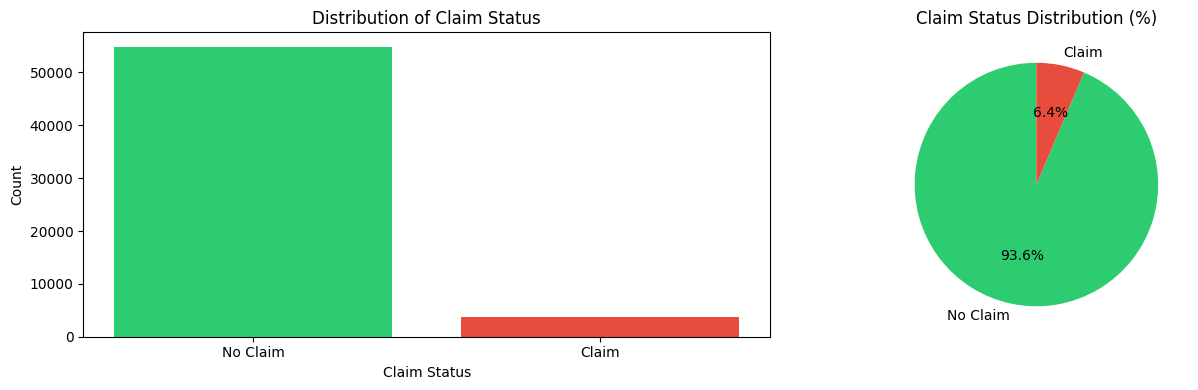

    Class balance (%):
    claim_status
    0    93.603222
    1     6.396778
    Name: proportion, dtype: float64

### 4.2 Numeric Features Distribution<a href="#4.2-Numeric-Features-Distribution" class="anchor-link">¶</a>

Analyze distributions of numeric features and their relationship with
the target.

In \[81\]:

    # Numeric feature distributions - first 6
    numeric_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features.remove('claim_status')

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for idx, col in enumerate(numeric_features[:6]):
        axes[idx].hist(
            df_clean[col],
            bins=30,
            color='steelblue',
            edgecolor='black',
            alpha=0.7
        )
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

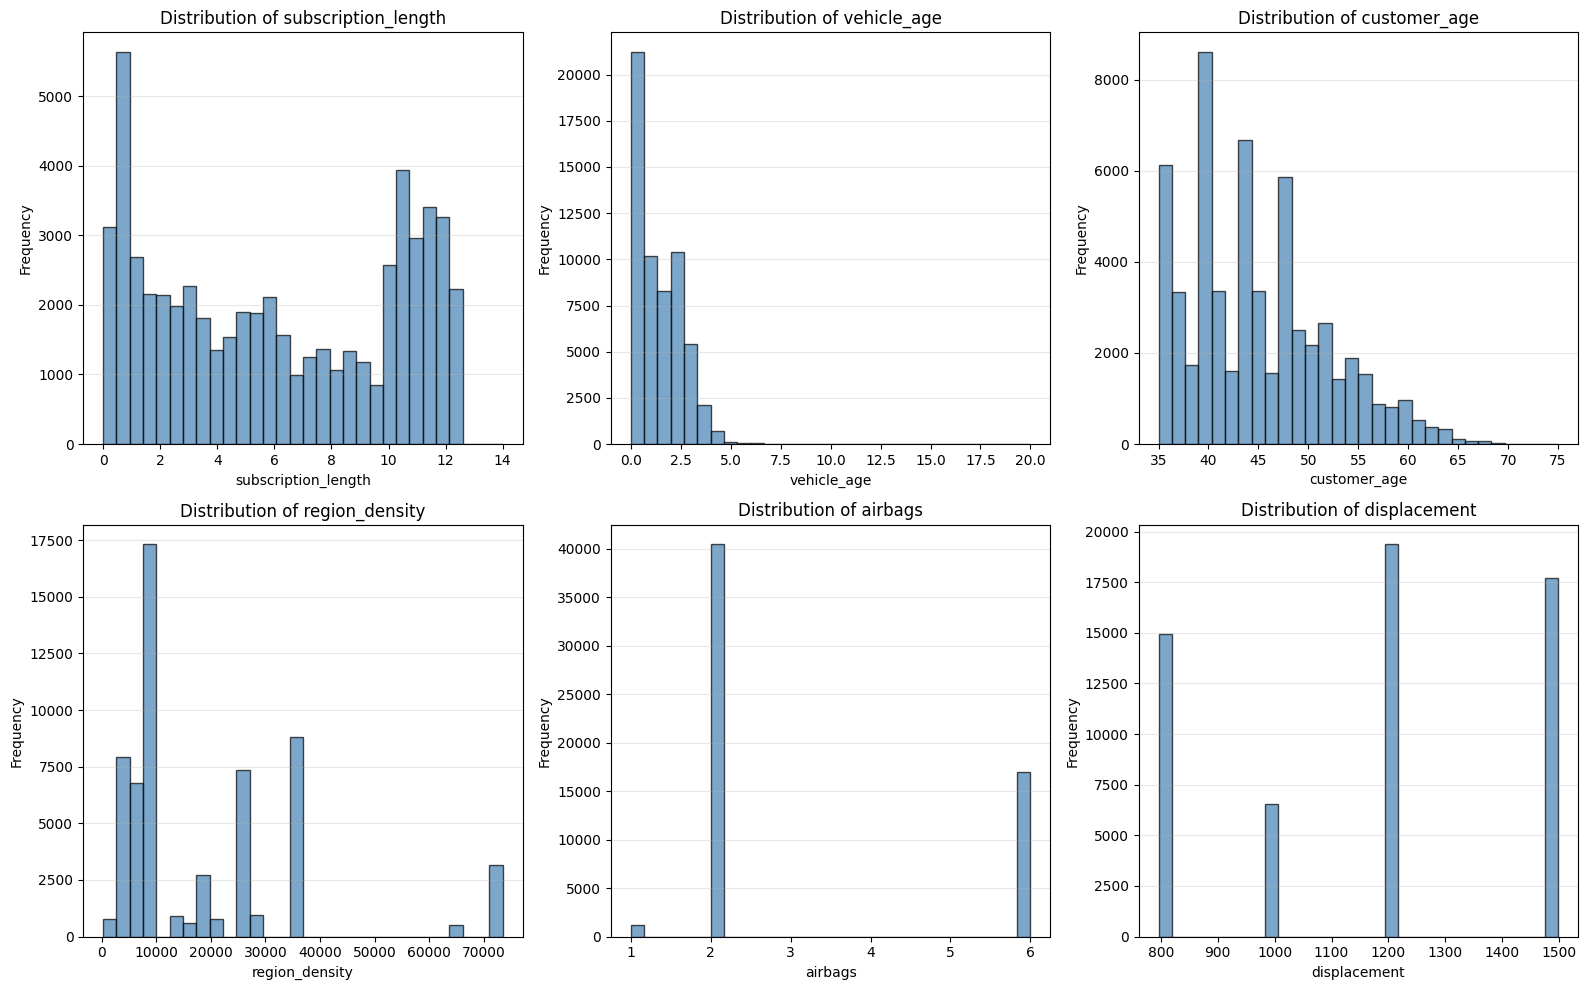

### 4.3 Correlation Analysis<a href="#4.3-Correlation-Analysis" class="anchor-link">¶</a>

Examine correlations between features and with the target variable.

In \[82\]:

    # Correlation 
    numeric_df = df_clean.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()


    # Display correlation values with claim_status 
    if 'claim_status' in correlation_matrix.columns:
        print("Correlation with Claim Status:")
        print(
            correlation_matrix['claim_status']
            .drop('claim_status')
            .sort_values(ascending=False)
        )

    # Heatmap of correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        correlation_matrix,
        annot=False,
        cmap='coolwarm',
        center=0,
        cbar_kws={'label': 'Correlation'}
    )
    plt.title('Correlation Matrix of Numeric Features')
    plt.tight_layout()
    plt.show()

    Correlation with Claim Status:
    subscription_length    0.078738
    customer_age           0.022234
    cylinder               0.013434
    width                  0.009947
    displacement           0.007678
    length                 0.006495
    gross_weight           0.003894
    ncap_rating            0.003800
    airbags                0.002789
    turning_radius         0.002724
    region_density        -0.017808
    vehicle_age           -0.028172
    Name: claim_status, dtype: float64

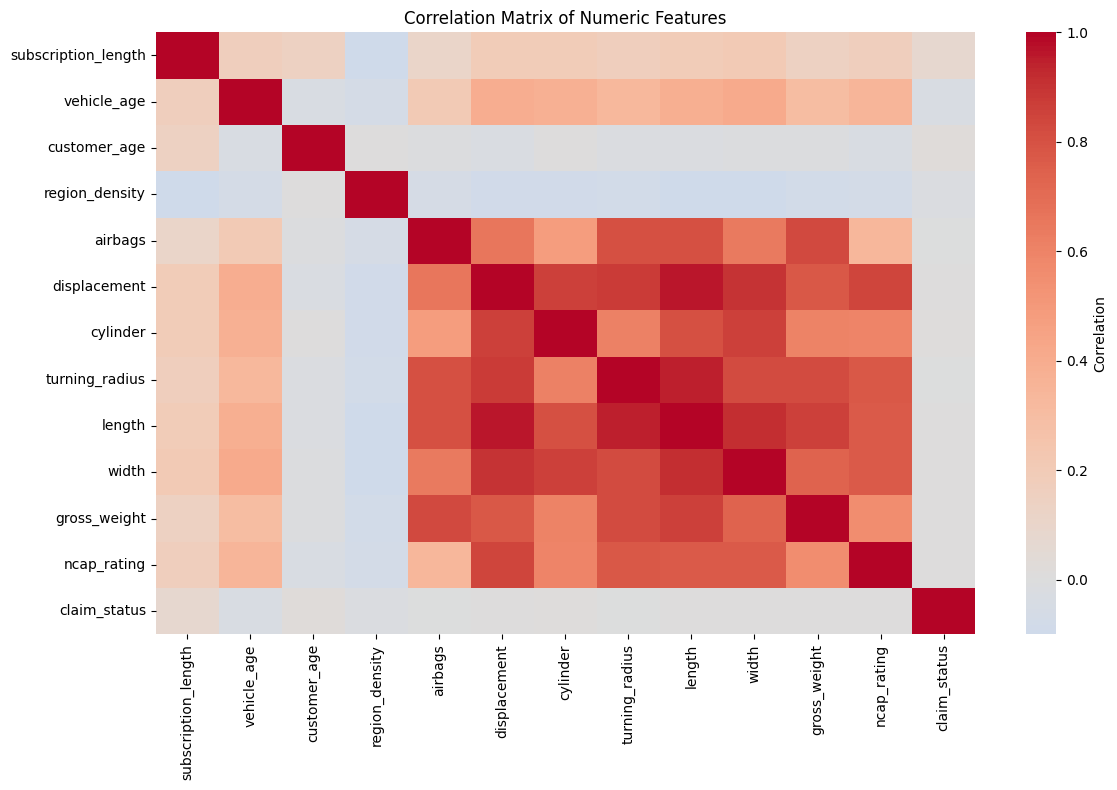

## 5. Train-Test Split & Feature Engineering<a href="#5.-Train-Test-Split-&amp;-Feature-Engineering"
class="anchor-link">¶</a>

In \[83\]:

    # Train Test Split

    target = 'claim_status'
    id_cols = ['policy_id'] if 'policy_id' in df_clean.columns else []

    X = df_clean.drop(columns=[target] + id_cols)
    y = df_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
       random_state=RANDOM_STATE,
        stratify=y
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Testing set size: {X_test.shape[0]}")

    print("\nClass distribution in training set:")
    print(y_train.value_counts(normalize=True))

    print("\nClass distribution in testing set:")
    print(y_test.value_counts(normalize=True))

    Training set size: 46873
    Testing set size: 11719

    Class distribution in training set:
    claim_status
    0    0.93604
    1    0.06396
    Name: proportion, dtype: float64

    Class distribution in testing set:
    claim_status
    0    0.936001
    1    0.063999
    Name: proportion, dtype: float64

## Feature Engineering<a href="#Feature-Engineering" class="anchor-link">¶</a>

Create new features from existing ones to improve model performance.

In \[84\]:

    # Feature Engineering 
    def add_engineered_features(df):

        df = df.copy()

        #Create age group features
        for col in df.columns:
            if 'age' in col.lower():
                df[f'{col}_group'] = pd.cut(
                    df[col],
                    bins=[0, 25, 35, 45, 55, 65, 100],
                    labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
                )

        #Premium to deductible ratio 
        premium_cols = [c for c in df.columns if 'premium' in c.lower()]
        deductible_cols = [c for c in df.columns if 'deductible' in c.lower()]

        if premium_cols and deductible_cols:
            premium_col = premium_cols[0]
            deductible_col = deductible_cols[0]
            df['premium_deductible_ratio'] = df[premium_col] / (df[deductible_col] + 1)

        #Squared term for duration/tenure (captures non linear effects)
        for col in df.columns:
            if 'duration' in col.lower() or 'tenure' in col.lower():
                df[f'{col}_squared'] = df[col] ** 2

        #Interaction: age * premium 
        age_cols = [c for c in df.columns if 'age' in c.lower() and 'group' not in c]
        if premium_cols and age_cols:
            df['age_premium_interaction'] = df[age_cols[0]] * df[premium_cols[0]]

        return df


    #Apply feature engineering to train and test separately
    X_train_fe = add_engineered_features(X_train)
    X_test_fe = add_engineered_features(X_test)

    print("Feature engineering completed.")
    print(f"Train features: {X_train.shape[1]}  →  {X_train_fe.shape[1]}")
    print(f"Test features:  {X_test.shape[1]}   →  {X_test_fe.shape[1]}")

    Feature engineering completed.
    Train features: 39  →  41
    Test features:  39   →  41

## 6. Feature Selection<a href="#6.-Feature-Selection" class="anchor-link">¶</a>

Select the most relevant features for modeling based on statistical and
ML-based methods.

In \[85\]:

    # Identify categorical and numeric columns 
    categorical_features = X_train_fe.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Numeric features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    print(f"\nTotal features before encoding: {X_train_fe.shape[1]}")

    # Correlation based quick scan 
    #for exploration/interpretation, not automatic feature dropping
    if numeric_features:
        numeric_corr = X_train_fe[numeric_features].corrwith(y_train).abs().sort_values(ascending=False)
        print("\nTop 10 correlated numeric features with target (training set only):")
        print(numeric_corr.head(10))

    Numeric features: 12
    Categorical features: 27

    Total features before encoding: 41

    Top 10 correlated numeric features with target (training set only):
    subscription_length    0.075642
    vehicle_age            0.029526
    customer_age           0.020889
    region_density         0.017392
    cylinder               0.008767
    width                  0.005414
    displacement           0.003997
    length                 0.002252
    ncap_rating            0.002103
    airbags                0.001104
    dtype: float64

## 7. Data Standardization<a href="#7.-Data-Standardization" class="anchor-link">¶</a>

Standardize features for ML models.

In \[86\]:

    # Identify categorical and numeric columns 
    categorical_features = X_train_fe.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Numeric features: {len(numeric_features)}")
    print(f"Categorical features: {len(categorical_features)}")

    # Preprocessing - fit on train only via Pipeline
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Compute class weights 
    classes = np.unique(y_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )
    class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

    print("\nClass weights:")
    print(class_weight_dict)

    Numeric features: 12
    Categorical features: 27

    Class weights:
    {np.int64(0): np.float64(0.5341652421652422), np.int64(1): np.float64(7.817378252168112)}

Given the class imbalance in the dataset, class weights are used for
models that support them to reduce bias toward the majority class.

## 8. Baseline Model: Naive Classifier<a href="#8.-Baseline-Model:-Naive-Classifier" class="anchor-link">¶</a>

Establish a benchmark by creating a simple baseline model that predicts
the majority class.

In \[87\]:

    # Baseline: Predict the majority class 
    majority_class = y_train.value_counts().idxmax()
    y_pred_baseline = np.full(len(y_test), majority_class)

    # Evaluate baseline
    baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
    baseline_precision = precision_score(y_test, y_pred_baseline, zero_division=0)
    baseline_recall = recall_score(y_test, y_pred_baseline, zero_division=0)
    baseline_f1 = f1_score(y_test, y_pred_baseline, zero_division=0)


    print("BASELINE MODEL: MAJORITY CLASS")

    print(f"\nAccuracy:  {baseline_accuracy:.4f}")
    print(f"Precision: {baseline_precision:.4f}")
    print(f"Recall:    {baseline_recall:.4f}")
    print(f"F1-Score:  {baseline_f1:.4f}")

    # Confusion matrix (numbers in a clear format)
    cm = confusion_matrix(y_test, y_pred_baseline)
    print("\nConfusion Matrix (rows = actual, columns = predicted):")
    print("                 Pred 0     Pred 1")
    print(f"Actual 0 (No):    {cm[0,0]:>6}   {cm[0,1]:>6}")
    print(f"Actual 1 (Yes):   {cm[1,0]:>6}   {cm[1,1]:>6}")

    print("\n" + "=" * 60)

    BASELINE MODEL: MAJORITY CLASS

    Accuracy:  0.9360
    Precision: 0.0000
    Recall:    0.0000
    F1-Score:  0.0000

    Confusion Matrix (rows = actual, columns = predicted):
                     Pred 0     Pred 1
    Actual 0 (No):     10969        0
    Actual 1 (Yes):      750        0

    ============================================================

The baseline model predicts No Claim for every policyholder, which
explains the high accuracy driven by class imbalance.

However, it fails to identify any actual claim cases, resulting in zero
precision, recall, and F1-score for the claim class.

The confusion matrix shows that all claim observations are misclassified
as non claims.

This model therefore serves only as a reference point and is not
suitable for real world claim prediction.

## 9. Model 1: Logistic Regression<a href="#9.-Model-1:-Logistic-Regression" class="anchor-link">¶</a>

Build a linear classification model using logistic regression. This is a
fast, interpretable baseline.

In \[88\]:

    log_reg_pipe = Pipeline([
        ('preprocess', preprocess),
        ('model', LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight=class_weight_dict
        ))
    ])

    # Train
    log_reg_pipe.fit(X_train_fe, y_train)

    # Predict
    y_pred_lr = log_reg_pipe.predict(X_test_fe)
    y_pred_proba_lr = log_reg_pipe.predict_proba(X_test_fe)[:, 1]

    # Metrics
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_precision = precision_score(y_test, y_pred_lr, zero_division=0)
    lr_recall = recall_score(y_test, y_pred_lr, zero_division=0)
    lr_f1 = f1_score(y_test, y_pred_lr, zero_division=0)
    lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

    print("Logistic Regression Results")
    print("-" * 40)
    print(f"Accuracy : {lr_accuracy:.4f}")
    print(f"Precision: {lr_precision:.4f}")
    print(f"Recall   : {lr_recall:.4f}")
    print(f"F1-score : {lr_f1:.4f}")
    print(f"ROC-AUC  : {lr_roc_auc:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_lr))

    # Store results
    models_results['Logistic Regression'] = {
        'accuracy': lr_accuracy,
        'precision': lr_precision,
        'recall': lr_recall,
        'f1': lr_f1,
        'roc_auc': lr_roc_auc
    }

    model_pipelines['Logistic Regression'] = log_reg_pipe

    Logistic Regression Results
    ----------------------------------------
    Accuracy : 0.5693
    Precision: 0.0879
    Recall   : 0.6107
    F1-score : 0.1536
    ROC-AUC  : 0.6255

    Confusion Matrix:
    [[6214 4755]
     [ 292  458]]

Logistic Regression achieves moderate discrimination, as reflected by a
ROC-AUC of 0.63.

The model prioritises identifying claim cases, achieving a recall of
about 61%, but at the cost of many false positives.

This leads to low precision and overall accuracy, as many non claim
policyholders are incorrectly flagged as claims.

Hence, the model is useful for understanding key relationships but is
less suitable for deployment due to its imbalance between precision and
recall.

## 10. Model 2: K-Nearest Neighbors (KNN)<a href="#10.-Model-2:-K-Nearest-Neighbors-(KNN)"
class="anchor-link">¶</a>

Implement a KNN classifier with hyperparameter tuning to find the
optimal number of neighbors.

In \[89\]:

    # Hyperparameter tuning for KNN 
    print("Tuning KNN hyperparameters...")

    knn_pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', KNeighborsClassifier())
    ])

    param_grid_knn = {
        'model__n_neighbors': [3, 5, 7, 9, 11, 15, 20]
    }

    knn_grid = GridSearchCV(
        knn_pipe,
        param_grid_knn,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Fit on training data 
    knn_grid.fit(X_train_fe, y_train)

    print(f"Best KNN parameters: {knn_grid.best_params_}")
    print(f"Best cross-validation ROC-AUC: {knn_grid.best_score_:.4f}")

    # Best KNN pipeline
    knn = knn_grid.best_estimator_

    # Evaluate on test data (after feature engineering)
    y_pred_knn = knn.predict(X_test_fe)
    y_pred_proba_knn = knn.predict_proba(X_test_fe)[:, 1]

    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    knn_precision = precision_score(y_test, y_pred_knn, zero_division=0)
    knn_recall = recall_score(y_test, y_pred_knn, zero_division=0)
    knn_f1 = f1_score(y_test, y_pred_knn, zero_division=0)
    knn_roc_auc = roc_auc_score(y_test, y_pred_proba_knn)


    print("K-NEAREST NEIGHBORS MODEL")

    print(f"\nAccuracy:  {knn_accuracy:.4f}")
    print(f"Precision: {knn_precision:.4f}")
    print(f"Recall:    {knn_recall:.4f}")
    print(f"F1-Score:  {knn_f1:.4f}")
    print(f"ROC-AUC:   {knn_roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_knn))
    print("=" * 60)

    # Add to results
    models_results['KNN'] = {
        'accuracy': knn_accuracy,
        'precision': knn_precision,
        'recall': knn_recall,
        'f1': knn_f1,
        'roc_auc': knn_roc_auc
    }
    model_pipelines['KNN'] = knn

    Tuning KNN hyperparameters...
    Best KNN parameters: {'model__n_neighbors': 20}
    Best cross-validation ROC-AUC: 0.5621
    K-NEAREST NEIGHBORS MODEL

    Accuracy:  0.9360
    Precision: 0.0000
    Recall:    0.0000
    F1-Score:  0.0000
    ROC-AUC:   0.5698

    Confusion Matrix:
    [[10969     0]
     [  750     0]]
    ============================================================

Despite tuning, the KNN model effectively predicts only the majority No
Claim class.

This results in high accuracy due to class imbalance, but zero
precision, recall, and F1-score for claim detection.

The confusion matrix confirms that all claim cases are misclassified as
non claims.

Overall, KNN performs poorly in this imbalanced setting and is not
suitable for identifying claim occurrences.

## 11. Model 3: Decision Tree Classifier<a href="#11.-Model-3:-Decision-Tree-Classifier"
class="anchor-link">¶</a>

Build a Decision Tree classifier with hyperparameter tuning to find
optimal tree depth and split criteria.

In \[90\]:

    # Hyperparameter tuning for Decision Tree with class weights
    print("Tuning Decision Tree hyperparameters...")

    param_grid_dt = {
        'model__max_depth': [5, 10, 15, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }

    dt_pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight=class_weight_dict))
    ])

    dt_grid = GridSearchCV(
        dt_pipe,
        param_grid_dt,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Fit on training data 
    dt_grid.fit(X_train_fe, y_train)

    print(f"Best Decision Tree parameters: {dt_grid.best_params_}")
    print(f"Best cross-validation ROC-AUC: {dt_grid.best_score_:.4f}")

    # Best estimator
    dt = dt_grid.best_estimator_

    # Predict on test data 
    y_pred_dt = dt.predict(X_test_fe)
    y_pred_proba_dt = dt.predict_proba(X_test_fe)[:, 1]

    # Evaluate Decision Tree
    dt_accuracy = accuracy_score(y_test, y_pred_dt)
    dt_precision = precision_score(y_test, y_pred_dt, zero_division=0)
    dt_recall = recall_score(y_test, y_pred_dt, zero_division=0)
    dt_f1 = f1_score(y_test, y_pred_dt, zero_division=0)
    dt_roc_auc = roc_auc_score(y_test, y_pred_proba_dt)

    print("\n" + "=" * 60)
    print("DECISION TREE CLASSIFIER MODEL")
    print("=" * 60)
    print(f"\nAccuracy:  {dt_accuracy:.4f}")
    print(f"Precision: {dt_precision:.4f}")
    print(f"Recall:    {dt_recall:.4f}")
    print(f"F1-Score:  {dt_f1:.4f}")
    print(f"ROC-AUC:   {dt_roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_dt))
    print("=" * 60)

    # Add to results
    models_results['Decision Tree'] = {
        'accuracy': dt_accuracy,
        'precision': dt_precision,
        'recall': dt_recall,
        'f1': dt_f1,
        'roc_auc': dt_roc_auc
    }
    model_pipelines['Decision Tree'] = dt

    Tuning Decision Tree hyperparameters...
    Best Decision Tree parameters: {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
    Best cross-validation ROC-AUC: 0.6429

    ============================================================
    DECISION TREE CLASSIFIER MODEL
    ============================================================

    Accuracy:  0.5303
    Precision: 0.0933
    Recall:    0.7267
    F1-Score:  0.1653
    ROC-AUC:   0.6538

    Confusion Matrix:
    [[5670 5299]
     [ 205  545]]
    ============================================================

The Decision Tree shows strong ability to identify claim cases,
achieving a high recall of approximately 73%.

This comes at the cost of many false positives, which lowers precision
and overall accuracy.

Its ROC-AUC of 0.65 indicates better discrimination than linear and
distance based models.

Overall, the Decision Tree effectively captures non linear patterns but
may over flag risk without further control.

To address the over sensitivity and improve stability, we extend this
approach using a Random Forest classifier.

## 12. Model 4: Random Forest Classifier<a href="#12.-Model-4:-Random-Forest-Classifier"
class="anchor-link">¶</a>

Train a Random Forest model which combines multiple decision trees for
improved performance and robustness.

In \[91\]:

    # Hyperparameter tuning for Random Forest with class weights
    print("Tuning Random Forest hyperparameters...")

    param_grid_rf = {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    }

    rf_pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('model', RandomForestClassifier(
            random_state=RANDOM_STATE,
            class_weight=class_weight_dict,
            n_jobs=-1
        ))
    ])

    rf_grid = GridSearchCV(
        rf_pipe,
        param_grid_rf,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Fit on training data 
    rf_grid.fit(X_train_fe, y_train)

    print(f"Best Random Forest parameters: {rf_grid.best_params_}")
    print(f"Best cross-validation ROC-AUC: {rf_grid.best_score_:.4f}")

    # Best estimator
    rf = rf_grid.best_estimator_

    # Predict on test data 
    y_pred_rf = rf.predict(X_test_fe)
    y_pred_proba_rf = rf.predict_proba(X_test_fe)[:, 1]

    # Evaluate Random Forest
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    rf_precision = precision_score(y_test, y_pred_rf, zero_division=0)
    rf_recall = recall_score(y_test, y_pred_rf, zero_division=0)
    rf_f1 = f1_score(y_test, y_pred_rf, zero_division=0)
    rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)


    print("RANDOM FOREST CLASSIFIER MODEL")

    print(f"\nAccuracy:  {rf_accuracy:.4f}")
    print(f"Precision: {rf_precision:.4f}")
    print(f"Recall:    {rf_recall:.4f}")
    print(f"F1-Score:  {rf_f1:.4f}")
    print(f"ROC-AUC:   {rf_roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_rf))


    # Add to results
    models_results['Random Forest'] = {
        'accuracy': rf_accuracy,
        'precision': rf_precision,
        'recall': rf_recall,
        'f1': rf_f1,
        'roc_auc': rf_roc_auc
    }
    model_pipelines['Random Forest'] = rf

    Tuning Random Forest hyperparameters...
    Best Random Forest parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 150}
    Best cross-validation ROC-AUC: 0.6378
    RANDOM FOREST CLASSIFIER MODEL

    Accuracy:  0.6481
    Precision: 0.1047
    Recall:    0.5960
    F1-Score:  0.1782
    ROC-AUC:   0.6611

    Confusion Matrix:
    [[7148 3821]
     [ 303  447]]

The Random Forest achieves the highest ROC-AUC of 0.66, indicating the
strongest overall discrimination between claim and non claim cases.

Compared to a single Decision Tree, it reduces overfitting by averaging
across multiple trees, leading to more stable predictions.

The model maintains a balanced trade-off, with reasonable recall while
improving precision and overall accuracy.

As a result, We can conclude that Random Forest gave us the best
combination of performance and robustness for predicting insurance claim
occurrence.

## 13. Model Comparison and Evaluation<a href="#13.-Model-Comparison-and-Evaluation" class="anchor-link">¶</a>

Compare all models using multiple evaluation metrics and identify the
best-performing model.

### 13.1 Results Comparison Table<a href="#13.1-Results-Comparison-Table" class="anchor-link">¶</a>

Display all models' performance metrics in a comprehensive comparison
table.

In \[92\]:

    results_df = pd.DataFrame(models_results).T.round(4)

    # Sort by ROC-AUC 
    if 'roc_auc' in results_df.columns:
        results_df = results_df.sort_values('roc_auc', ascending=False)
    else:
        results_df = results_df.sort_values('f1', ascending=False)

    print("\n" + "=" * 80)
    print("MODEL COMPARISON SUMMARY")
    print("=" * 80)
    print(results_df)
    print("=" * 80)

    ================================================================================
    MODEL COMPARISON SUMMARY
    ================================================================================
                         accuracy  precision  recall      f1  roc_auc
    Random Forest          0.6481     0.1047  0.5960  0.1782   0.6611
    Decision Tree          0.5303     0.0933  0.7267  0.1653   0.6538
    Logistic Regression    0.5693     0.0879  0.6107  0.1536   0.6255
    KNN                    0.9360     0.0000  0.0000  0.0000   0.5698
    Baseline               0.9360     0.0000  0.0000  0.0000      NaN
    ================================================================================

In \[93\]:

    # Visualization of metric comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        values = results_df[metric].values
        models = results_df.index.tolist()

        colors = [model_colors[m] for m in models]

        bars = ax.bar(
            range(len(models)),
            values,
            color=colors,
            edgecolor='black',
            alpha=0.75
        )

        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.upper()} Comparison')
        ax.set_xticks(range(len(models)))
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)

        # Value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.3f}',
                ha='center',
                va='bottom',
                fontsize=9
            )

    plt.tight_layout()
    plt.show()

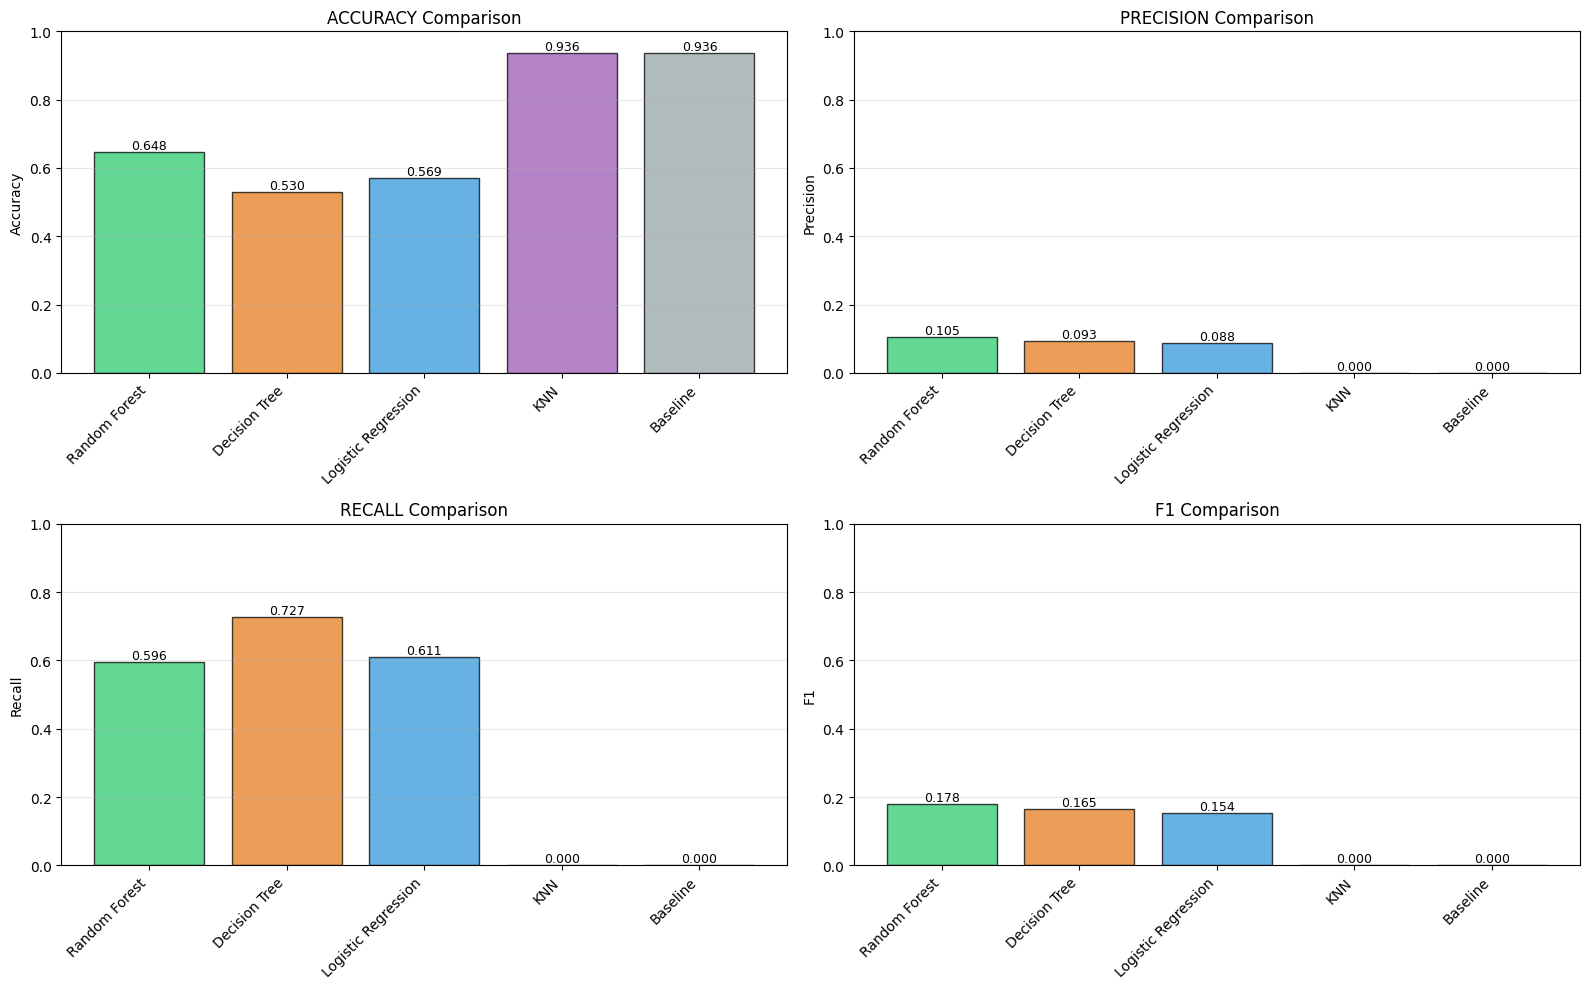

Random Forest still offers the best overall balance, improving F1-score
and achieving the strongest trade-off between detecting claims and
controlling false alarms.

### 13.2 ROC Curves Comparison<a href="#13.2-ROC-Curves-Comparison" class="anchor-link">¶</a>

Plot ROC curves for all models to visualize their discrimination
performance.

In \[94\]:

    plt.figure(figsize=(10, 8))

    for model_name, model in model_pipelines.items():
        #plot ROC if the model can output probabilities
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test_fe)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_auc_value = auc(fpr, tpr)

            plt.plot(
                fpr,
                tpr,
                label=f"{model_name} (AUC = {roc_auc_value:.3f})",
                linewidth=2.5,
                color=model_colors.get(model_name, "steelblue")  # fallback color
            )

    # Random classifier reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=2)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Model Comparison')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

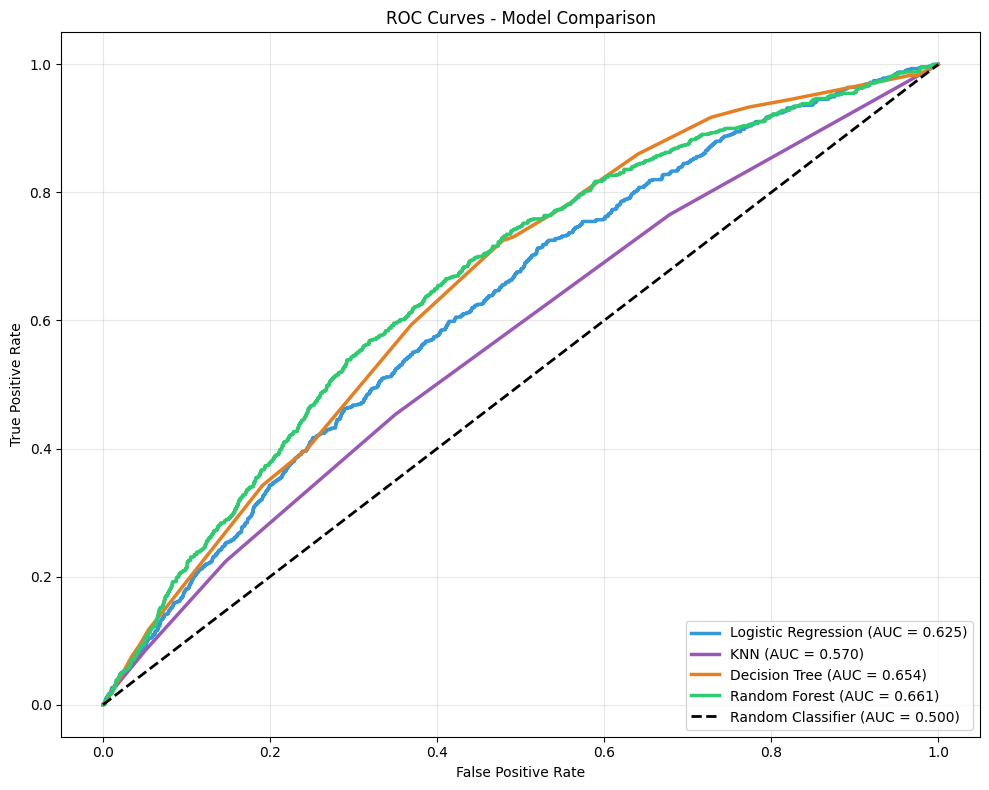

The Random Forest ROC curve dominates the others, meaning it achieves
higher true positive rates for most false positive levels, which
explains its higher ROC-AUC

### 13.3 Confusion Matrices Visualization<a href="#13.3-Confusion-Matrices-Visualization"
class="anchor-link">¶</a>

Display confusion matrices for all models to understand prediction
patterns.

In \[95\]:

    print("Models available in model_pipelines:")
    print(list(model_pipelines.keys()))

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    # Pick the models to display
    model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']

    plotted = 0

    for ax, model_name in zip(axes, model_names):
        if model_name not in model_pipelines:
            ax.set_title(f"{model_name} not found")
            ax.axis("off")
            continue

        model = model_pipelines[model_name]

        y_pred = model.predict(X_test_fe)
        cm = confusion_matrix(y_test, y_pred)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Claim', 'Claim'])
        disp.plot(ax=ax, cmap='Blues', values_format='d', colorbar=False)

        ax.set_title(f'{model_name} - Confusion Matrix')
        plotted += 1

    # If nothing plotted, tell me
    if plotted == 0:
        print("\nNo confusion matrices.")
        print("Fix.")

    plt.tight_layout()
    plt.show()

    Models available in model_pipelines:
    ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']

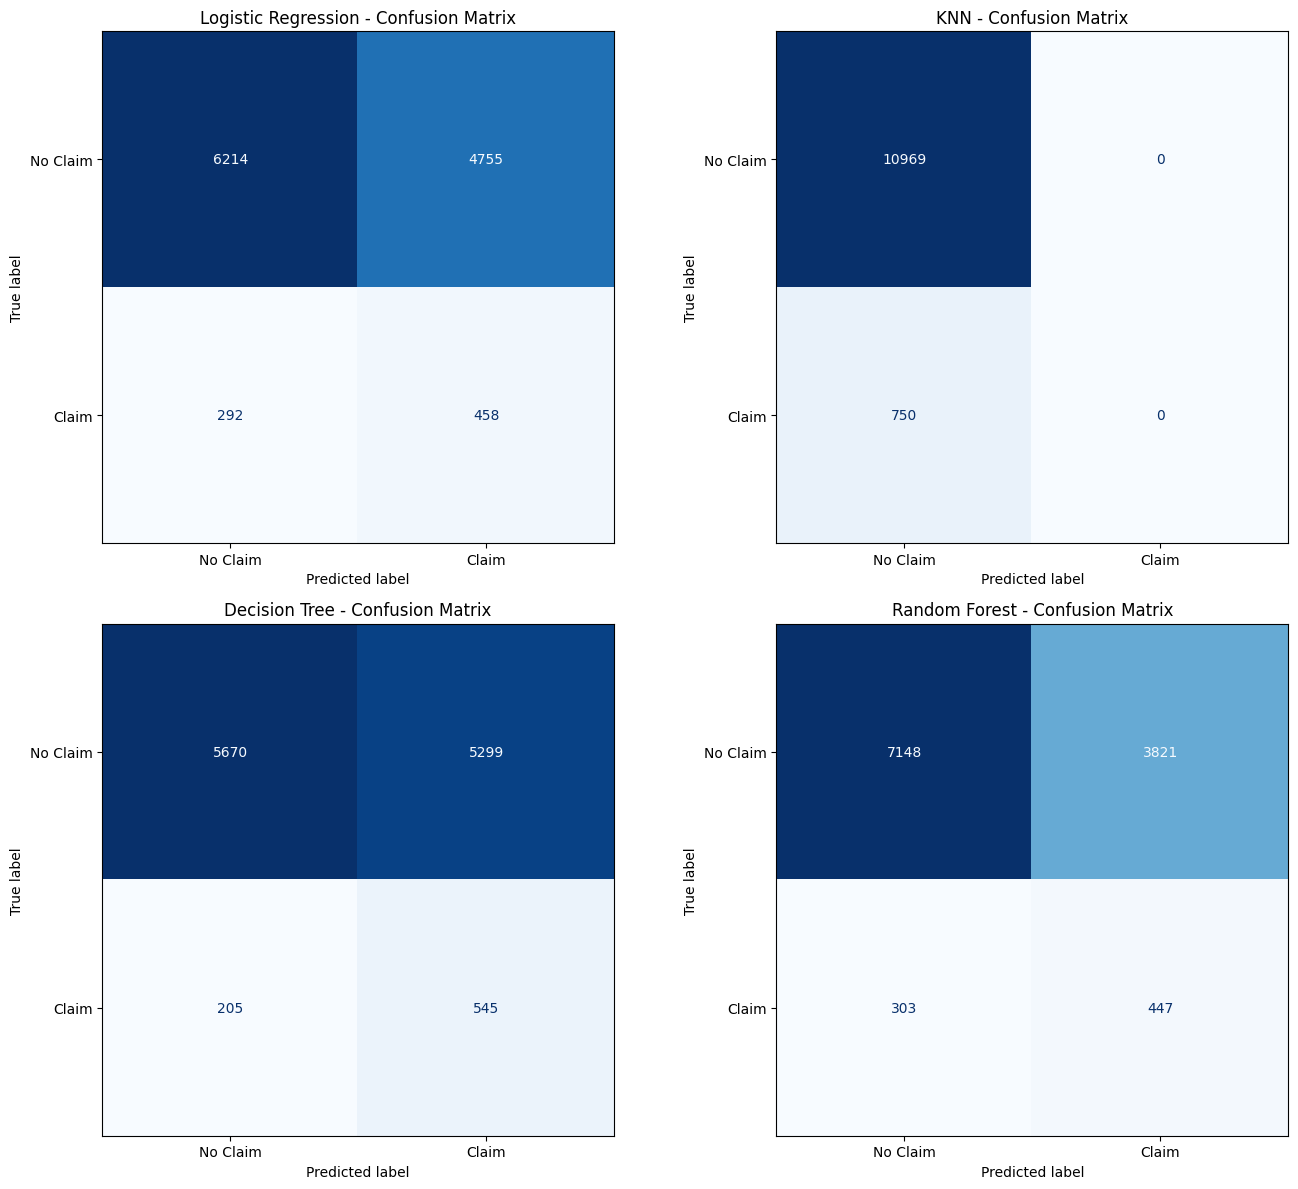

### 13.4 Best Model Selection and Saving<a href="#13.4-Best-Model-Selection-and-Saving"
class="anchor-link">¶</a>

Identify the best-performing model and save all models to the models
folder.

In \[96\]:

    # Choose selection metric (We choose based on ROC-AUC if, else F1)
    selection_metric = 'roc_auc'

    if selection_metric in results_df.columns:
        # Drop models with missing ROC-AUC (e.g., Baseline)
        valid_results = results_df.dropna(subset=[selection_metric])
    else:
        selection_metric = 'f1'
        valid_results = results_df

    best_model_name = valid_results[selection_metric].idxmax()
    best_model_score = valid_results[selection_metric].max()


    print("FINAL RECOMMENDATION")

    print(f"\nBest Performing Model: {best_model_name}")
    print(f"{selection_metric.upper()} Score: {best_model_score:.4f}")
    print(f"\nModel Performance Summary:")
    print(results_df.loc[best_model_name])
    print("=" * 80)

    # Select the best model pipeline
    best_model = model_pipelines[best_model_name]

    # Create models directory 
    models_dir = preprocessed_output_data_path + "/models"

    import os
    os.makedirs(models_dir, exist_ok=True)

    print(f"\nSaving all models to: {models_dir}")

    # Save all models
    for model_name, model_pipeline in model_pipelines.items():
        model_filename = f"{model_name.lower().replace(' ', '_')}_model.sav"
        model_path = models_dir + "/" + model_filename
        joblib.dump(model_pipeline, model_path)
        print(f"  ✓ Saved: {model_filename}")

    # Save best model separately
    best_model_path = models_dir + "/best_model.sav"
    joblib.dump(best_model, best_model_path)
    print(f"  ✓ Saved: best_model.sav (Best performer: {best_model_name})")

    print(f"\nAll models saved successfully to: {models_dir}")

    FINAL RECOMMENDATION

    Best Performing Model: Random Forest
    ROC_AUC Score: 0.6611

    Model Performance Summary:
    accuracy     0.6481
    precision    0.1047
    recall       0.5960
    f1           0.1782
    roc_auc      0.6611
    Name: Random Forest, dtype: float64
    ================================================================================

    Saving all models to: ../data/output/models
      ✓ Saved: logistic_regression_model.sav
      ✓ Saved: knn_model.sav
      ✓ Saved: decision_tree_model.sav
      ✓ Saved: random_forest_model.sav
      ✓ Saved: best_model.sav (Best performer: Random Forest)

    All models saved successfully to: ../data/output/models

## 14. Key Findings and Conclusions<a href="#14.-Key-Findings-and-Conclusions" class="anchor-link">¶</a>

Final Summary (Presentation Version)

Problem This project focused on predicting whether a policyholder will
file an insurance claim using historical demographic and policy data.
The task was framed as a binary classification problem under class
imbalance.

Methodology We followed a standard machine learning pipeline: data
cleaning, exploratory analysis, train–test split to avoid data leakage,
feature engineering, and model evaluation. Multiple models were
compared, including Logistic Regression, KNN, Decision Tree, and Random
Forest. All preprocessing and transformations were applied within
pipelines to ensure a fair comparison.

Results All models outperformed the baseline classifier. Among them,
Random Forest achieved the highest ROC-AUC, indicating the strongest
ability to discriminate between claim and non-claim cases across
thresholds. It also provided a good balance between recall and overall
accuracy.

Conclusion Based on both statistical performance and practical
considerations, Random Forest was selected as the final model. It
captures non-linear relationships, handles feature interactions well,
and is suitable for deployment in an insurance risk assessment setting.

In \[ \]: